<a href="https://colab.research.google.com/github/ikramMc/PFE/blob/main/Extaraction_and_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install Pillow==9.5.0 torch==2.3.1 torchaudio==2.3.1 torchvision==0.18.1 transformers==4.44.2 librosa==0.9.0 soundfile==0.12.1 vector-quantize-pytorch==1.18.5 vocos==0.1.0 decord moviepy
#!pip install flash_attn


In [ ]:
!pip install requests beautifulsoup4 markdownify

  Using cached markdownify-1.1.0-py3-none-any.whl.metadata (9.1 kB)
Using cached markdownify-1.1.0-py3-none-any.whl (13 kB)


In [ ]:
# Step 1: Install Chrome, ChromeDriver, and other dependencies
!apt-get update
!apt-get install -y wget curl unzip
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt --fix-broken install -y

# Step 2: Install required Python packages
!pip install selenium webdriver-manager



Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,801 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,748 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,587 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,058 kB]
Get:13 http://archive.ub

# **MiniCPM Model loading**

In [ ]:
%%capture
!git clone https://github.com/OpenBMB/AutoGPTQ.git
%cd AutoGPTQ
!git checkout minicpmo
%pip install -vv --no-build-isolation -e .

In [ ]:

import torch
from transformers import AutoModel,AutoTokenizer
from auto_gptq import AutoGPTQForCausalLM

model=AutoGPTQForCausalLM.from_quantized(
    'openbmb/MiniCPM-o-2_6-int4',
    torch_dtype=torch.bfloat16,
    device='cuda:0',
    trust_remote_code=True,
    disable_exllama=True,
    disable_exllamav2=True
)
tokenizer=AutoTokenizer.from_pretrained('openbmb/MiniCPM-o-2_6-int4',trust_remote_code=True)
model.init_tts()


# **File and Image retrieval**

**Hacktricks**

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import os
from pathlib import Path
import re
from markdownify import markdownify as md
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

# --- Phase 1 : Scraping des liens depuis le site HackTricks ---

# Configuration Chrome headless
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Lancement du navigateur
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get("https://book.hacktricks.wiki/en/")
time.sleep(3)

soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

# Extraction des liens du menu latéral
sidebar = soup.find("mdbook-sidebar-scrollbox", class_="sidebar-scrollbox")
if not sidebar:
    raise Exception("❌ Sidebar not found!")

chapter_list = sidebar.find("ol", class_="chapter")
if not chapter_list:
    raise Exception("❌ Couldn't find <ol class='chapter'> inside the sidebar.")

li_elements = chapter_list.find_all("li")

# Marqueurs de début et de fin
start_marker = "🤩 Generic Methodologies & Resources"
end_marker = "✍️ TODO"
start_index = end_index = None

for i, el in enumerate(li_elements):
    text = el.get_text(strip=True)
    if start_marker in text:
        start_index = i
    if end_marker in text:
        end_index = i

if start_index is None or end_index is None:
    raise Exception("❌ Marqueurs non trouvés dans le sommaire.")

# Liens extraits (correction avec urljoin)
base_url = "https://book.hacktricks.wiki/en/"
extracted_urls = []

for el in li_elements[start_index + 1:end_index]:
    link = el.find("a", href=True)
    if link:
        href = link["href"]
        full_url = urljoin(base_url, href)
        extracted_urls.append(full_url)

print(f"\n✅ {len(extracted_urls)} URLs extraites depuis la sidebar.")

# --- Phase 2 : Téléchargement du contenu Markdown + images ---

os.makedirs("hacktricks_pages/images", exist_ok=True)

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 ' +
                  '(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

# Nombre de liens à traiter
max_links = 883
processed_links_file = "processed_links.txt"

# Charger les liens déjà traités
if os.path.exists(processed_links_file):
    with open(processed_links_file, "r") as f:
        processed_links = set(f.read().splitlines())
else:
    processed_links = set()

# Traitement des liens
processed_count = 0
for full_url in extracted_urls:
    if full_url in processed_links:
        #print(f"⚠️ Déjà traité : {full_url}")
        continue

    #print(f"\n🔗 Traitement de : {full_url}")
    try:
        res = requests.get(full_url, headers=HEADERS)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")

        content_div = soup.find("div", class_="content")
        if not content_div:
            raise Exception("❌ Contenu principal non trouvé.")

        # Téléchargement et remplacement des images
        for img in content_div.find_all("img"):
            img_url = img.get("src")
            if not img_url:
                continue
            full_img_url = urljoin(full_url, img_url)
            try:
                img_data = requests.get(full_img_url, headers=HEADERS).content
                filename = os.path.basename(urlparse(img_url).path)
                if not filename:
                    continue
                filepath = os.path.join("hacktricks_pages/images", filename)
                with open(filepath, "wb") as f:
                    f.write(img_data)
                img["src"] = f"images/{filename}"
            except Exception as e:
                print(f"⚠️ Erreur image : {full_img_url} -> {e}")

        # Nettoyage et conversion en Markdown
        for tag in content_div.find_all(["script", "style", "iframe"]):
            tag.decompose()

        markdown_text = md(str(content_div), heading_style="ATX")
        markdown_text = re.sub(r'\[!\[expand\]\(.*?\)\]\(javascript:void\(0\).*?\)', '', markdown_text)

        # Création du nom de fichier Markdown avec gestion des fichiers "index"
        parsed_url = urlparse(full_url)
        path_parts = parsed_url.path.strip("/").split("/")
        file_base = path_parts[-1] or "index"

        if file_base == "index.html" and len(path_parts) >= 2:
            prefix = path_parts[-2]
            print(prefix)
            file_base = f"{prefix}_index"

        file_base = re.sub(r'\W+', '_', file_base)  # Nettoyage du nom
        md_path = Path(f"hacktricks_pages/{file_base}.md")

        with open(md_path, "w", encoding="utf-8") as f:
            f.write(markdown_text)

        #print(f"✅ Page enregistrée : {md_path.name}")

        # Marquer le lien comme traité
        with open(processed_links_file, "a") as f:
            f.write(full_url + "\n")

        processed_links.add(full_url)
        processed_count += 1

        # Arrêter après avoir traité le nombre de liens spécifié
        if processed_count >= max_links:
            #print(f"✅ Nombre de liens traités atteint : {max_links}")
            break

    except Exception as e:
        print(f"❌ Erreur : {full_url} -> {e}")

print(f"\n✅ Traitement terminé. {processed_count} liens traités.")



✅ 912 URLs extraites depuis la sidebar.
pcap-inspection
specific-software-file-type-tricks
⚠️ Erreur image : https://book.hacktricks.wiki/en/images/image%20(477)%20(2)%20(2)%20(2)%20(2)%20(2)%20(2)%20(2)%20(3)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(10)%20(14)%20(2).png -> [Errno 36] File name too long: 'hacktricks_pages/images/image%20(477)%20(2)%20(2)%20(2)%20(2)%20(2)%20(2)%20(2)%20(3)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(1)%20(10)%20(14)%20(2).png'
windows-forensics
python
bypass-python-sandboxes
reverse-shells
privilege-escalation
docker-security
⚠️ Erreur image : https://bestestredteam.com/content/images/2019/08/image-16.png -> HTTPSConnectio

# **Transformation and Cleaning**

In [ ]:
!git clone https://github.com/ikramMc/md-cleaning.git

Cloning into 'md-cleaning'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 4.73 KiB | 4.73 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
regex_content = """
^\s*reading time:.*$
^\s*tip\s*$
(?im)^###\s+more\s*$ ==> CUT_AFTER_MATCH
!\[.*?\]\(.*?\)
\[([^\]]+)\]\([^)]+\) ==> \1
\([#][^)]+\)
^(#{2,6})\s*\d+\s*[-–]\s* ==> \1
[ ]{2,} ==>
(?is)(Learn\s*&\s*practice.*?)(?:Share hacking tricks.*?github repos\.)
(?is)^##\s*\[references\][\s\S]*$
"""

with open("patterns.txt", "w", encoding="utf-8") as f:
    f.write(regex_content.strip())

print("✅ Fichier 'patterns.txt' créé.")


✅ Fichier 'patterns.txt' créé.


In [ ]:
!python md-cleaning/cleaning-script.py --input hacktricks_pages --regex-file patterns.txt --remove-non-ascii true --output cleaned/

📂 794 fichiers trouvés dans hacktricks_pages
✅ xpath_injection_html.md nettoyé → xpath_injection_html.md
✅ house_of_einherjar_html.md nettoyé → house_of_einherjar_html.md
✅ git_html.md nettoyé → git_html.md
✅ ad_information_in_printers_html.md nettoyé → ad_information_in_printers_html.md
✅ 3128_pentesting_squid_html.md nettoyé → 3128_pentesting_squid_html.md
✅ stealing_credentials_index.md nettoyé → stealing_credentials_index.md
✅ unlink_attack_html.md nettoyé → unlink_attack_html.md
✅ rop_leaking_libc_address_index.md nettoyé → rop_leaking_libc_address_index.md
✅ 44134_pentesting_tiller_helm_html.md nettoyé → 44134_pentesting_tiller_helm_html.md
✅ harvesting_tickets_from_linux_html.md nettoyé → harvesting_tickets_from_linux_html.md
✅ image_acquisition_and_mount_html.md nettoyé → image_acquisition_and_mount_html.md
✅ AI_Deep_Learning_html.md nettoyé → AI_Deep_Learning_html.md
✅ docker_security_index.md nettoyé → docker_security_index.md
✅ cookie_bomb_onerror_xs_leak_html.md nettoyé → c

# **File Exploration**

In [ ]:
from transformers import AutoTokenizer
import os


token = os.getenv("HF_token")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3", token=token)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
import os
import matplotlib.pyplot as plt

FOLDER_PATH = "/content/cleaned"  # update this if needed

file_stats = []

for filename in os.listdir(FOLDER_PATH):
    # Only process .md files that start with "modified"
    if filename.endswith('.md') :
        file_path = os.path.join(FOLDER_PATH, filename)

        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()
                token_ids = tokenizer.encode(text, add_special_tokens=False)
                unique_token_ids = set(token_ids)

                file_stats.append({
                    "filename": filename,
                    "size_bytes": os.path.getsize(file_path),
                    "num_tokens": len(token_ids),
                    "unique_tokens": len(unique_token_ids),
                    "diversity": len(unique_token_ids) / len(token_ids) if token_ids else 0
                })

In [ ]:
import statistics

token_counts = [f['num_tokens'] for f in file_stats]

min_tokens = min(token_counts)
max_tokens = max(token_counts)
mean_tokens = statistics.mean(token_counts)
median_tokens = statistics.median(token_counts)

print(f"📊 File token stats:")
print(f"  ➤ Min: {min_tokens} tokens")
print(f"  ➤ Max: {max_tokens} tokens")
print(f"  ➤ Mean: {mean_tokens:.2f} tokens")
print(f"  ➤ Median: {median_tokens} tokens")
print(f"🔢 Total number of tokens across all files:{sum(token_counts)}")

📊 File token stats:
  ➤ Min: 29 tokens
  ➤ Max: 25591 tokens
  ➤ Mean: 2778.85 tokens
  ➤ Median: 1521.0 tokens
🔢 Total number of tokens across all files:2206408


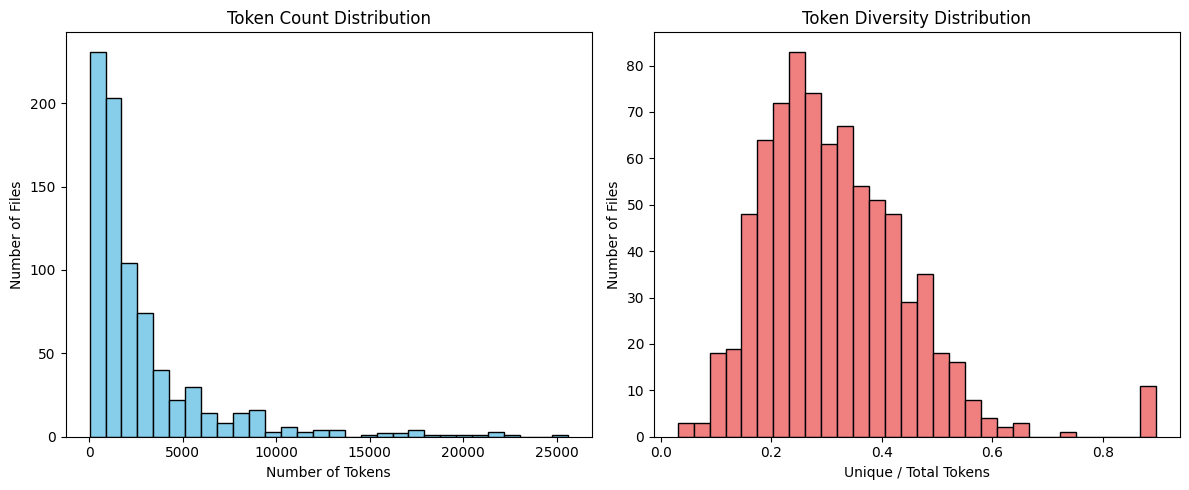

In [ ]:
token_counts = [f['num_tokens'] for f in file_stats]
diversities = [f['diversity'] for f in file_stats]
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Token Count Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Files")

plt.subplot(1, 2, 2)
plt.hist(diversities, bins=30, color='lightcoral', edgecolor='black')
plt.title("Token Diversity Distribution")
plt.xlabel("Unique / Total Tokens")
plt.ylabel("Number of Files")

plt.tight_layout()
plt.show()

In [ ]:
!zip -r cleaned.zip cleaned/


  adding: cleaned/ (stored 0%)
  adding: cleaned/xpath_injection_html.md (deflated 65%)
  adding: cleaned/house_of_einherjar_html.md (deflated 56%)
  adding: cleaned/git_html.md (deflated 52%)
  adding: cleaned/ad_information_in_printers_html.md (deflated 47%)
  adding: cleaned/3128_pentesting_squid_html.md (deflated 49%)
  adding: cleaned/stealing_credentials_index.md (deflated 61%)
  adding: cleaned/unlink_attack_html.md (deflated 60%)
  adding: cleaned/rop_leaking_libc_address_index.md (deflated 60%)
  adding: cleaned/44134_pentesting_tiller_helm_html.md (deflated 56%)
  adding: cleaned/harvesting_tickets_from_linux_html.md (deflated 47%)
  adding: cleaned/image_acquisition_and_mount_html.md (deflated 54%)
  adding: cleaned/AI_Deep_Learning_html.md (deflated 67%)
  adding: cleaned/docker_security_index.md (deflated 61%)
  adding: cleaned/cookie_bomb_onerror_xs_leak_html.md (deflated 7%)
  adding: cleaned/4840_pentesting_opc_ua_html.md (deflated 42%)
  adding: cleaned/format_strings_

In [ ]:
!zip -r hacktricksl.zip hacktricks_pages/


  adding: hacktricks_pages/ (stored 0%)
  adding: hacktricks_pages/xpath_injection_html.md (deflated 67%)
  adding: hacktricks_pages/house_of_einherjar_html.md (deflated 66%)
  adding: hacktricks_pages/git_html.md (deflated 68%)
  adding: hacktricks_pages/ad_information_in_printers_html.md (deflated 63%)
  adding: hacktricks_pages/3128_pentesting_squid_html.md (deflated 65%)
  adding: hacktricks_pages/stealing_credentials_index.md (deflated 64%)
  adding: hacktricks_pages/unlink_attack_html.md (deflated 66%)
  adding: hacktricks_pages/rop_leaking_libc_address_index.md (deflated 63%)
  adding: hacktricks_pages/44134_pentesting_tiller_helm_html.md (deflated 67%)
  adding: hacktricks_pages/harvesting_tickets_from_linux_html.md (deflated 67%)
  adding: hacktricks_pages/image_acquisition_and_mount_html.md (deflated 64%)
  adding: hacktricks_pages/AI_Deep_Learning_html.md (deflated 68%)
  adding: hacktricks_pages/docker_security_index.md (deflated 64%)
  adding: hacktricks_pages/cookie_bomb_

# **Image2Text**

In [ ]:
%%capture
#fix model response
import re
from PIL import Image
from pathlib import Path
# Assumed model and tokenizer setup
# from your_model_library import model, tokenizer  # Uncomment this and set up your model

# Récupérer tous les fichiers markdown modifiés
modified_files = list(Path().glob("modified_*.md"))

for md_path in modified_files:
    print(f"\n📄 Traitement du fichier : {md_path.name}")
    try:
        with open(md_path, "r", encoding="utf-8") as f:
            md_content = f.read()

        # Expression régulière mise à jour pour trouver les images
        img_pattern = r"!\[\]\((images/.*?\.png)\)"  # Adaptation pour correspondre aux images PNG
        matches = re.findall(img_pattern, md_content)

        for img_path in matches:
            print(f"🖼️ Traitement de l'image : {img_path}")
            try:
                # Ouvrir l'image
                image = Image.open(img_path).convert("RGB")

                # Définir la question pour décrire l'image
                question = (
                    "you work as an assistant to a blind pentester so "
                    "you need to extract all the information needed for pentesting. "
                    "First, describe what the image is briefly to the pentester, then if the image shows raw text, extract it."
                )
                # Préparer le message pour l'API du modèle
                msgs = [{'role': 'user', 'content': question, 'image': image}]

                # Remarque : ici, tu dois configurer comment utiliser le modèle
                # res = model.chat(image=image, msgs=msgs, tokenizer=tokenizer)  # Remplace ceci par ton appel réel au modèle

                # Exemple de réponse simulée
                res = "This is a description of the image, and if there was text in it, it would be extracted."

                print("✅ Réponse du LLM obtenue.")

                # Formatage de la réponse pour remplacer l'image par la description
                formatted_resp = f"\n<!--LLM_DESC_START-->\n{res}\n<!--LLM_DESC_END-->\n"

                # Remplacer l'image dans le contenu Markdown
                md_content = md_content.replace(f"![{Path(img_path).stem}]({img_path})", formatted_resp)

            except Exception as e:
                print(f"⚠️ Erreur avec l'image {img_path} : {e}")

        # Sauvegarder le fichier mis à jour
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(md_content)

        print(f"✅ Fichier mis à jour avec descriptions LLM : {md_path.name}")

    except Exception as e:
        print(f"❌ Erreur lors du traitement LLM des images dans {md_path.name} : {e}")
